# MCMC Sampling

The  `CmdStanModel` class method  `sample` invokes Stan's adaptive HMC-NUTS
sampler which uses the Hamiltonian Monte Carlo (HMC) algorithm
and its adaptive variant the no-U-turn sampler (NUTS) to produce a set of
draws from the posterior distribution of the model parameters conditioned on the data.
It returns a `CmdStanMCMC` object
which provides properties to retrieve information about the sample, as well as methods
to run CmdStan's summary and diagnostics tools.

In order to evaluate the fit of the model to the data, it is necessary to run
several Monte Carlo chains and compare the set of draws returned by each.
By default, the `sample` command runs 4 sampler chains, i.e.,
CmdStanPy invokes CmdStan 4 times.
CmdStanPy uses Python's `subprocess` and `multiprocessing` libraries
to run these chains in separate processes.
This processing can be done in parallel, up to the number of
processor cores available.

## Fitting a model to data

In this example we use the CmdStan example model
[bernoulli.stan](https://github.com/stan-dev/cmdstanpy/blob/master/test/data/bernoulli.stan)
and data file
[bernoulli.data.json](https://github.com/stan-dev/cmdstanpy/blob/master/test/data/bernoulli.data.json>).

We instantiate a `CmdStanModel` from the Stan program file

In [1]:
import os
from cmdstanpy.model import CmdStanModel
from cmdstanpy.utils import cmdstan_path
    
bernoulli_dir = os.path.join(cmdstan_path(), 'examples', 'bernoulli')
bernoulli_path = os.path.join(bernoulli_dir, 'bernoulli.stan')
bernoulli_data = os.path.join(bernoulli_dir, 'bernoulli.data.json')

# instantiate, compile bernoulli model
bernoulli_model = CmdStanModel(stan_file=bernoulli_path)

INFO:cmdstanpy:found newer exe file, not recompiling


INFO:cmdstanpy:compiled model file: /home/nick/.cmdstan/cmdstan-2.27.0/examples/bernoulli/bernoulli


By default, the model is compiled during instantiation.  The compiled executable is created in the same directory as the program file.  If the directory already contains an executable file with a newer timestamp, the model is not recompiled.

We run the sampler on the data using all default settings:  4 chains, each of which runs 1000 warmup and sampling iterations.

In [2]:
# run CmdStan's sample method, returns object `CmdStanMCMC`
bern_fit = bernoulli_model.sample(data=bernoulli_data)

INFO:cmdstanpy:start chain 1


INFO:cmdstanpy:start chain 2


INFO:cmdstanpy:start chain 3


INFO:cmdstanpy:start chain 4


INFO:cmdstanpy:finish chain 1


INFO:cmdstanpy:finish chain 2


INFO:cmdstanpy:finish chain 3


INFO:cmdstanpy:finish chain 4


The `sample` method returns a `CmdStanMCMC` object, which contains:
- metadata
- draws
- HMC tuning parameters `metric`, `step_size`

In [3]:
print('sampler diagnostic variables:\n{}'.format(bern_fit.metadata.method_vars_cols.keys()))
print('stan model variables:\n{}'.format(bern_fit.metadata.stan_vars_cols.keys()))

AttributeError: 'CmdStanMCMC' object has no attribute 'metadata'

In [4]:
bern_fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-7.30,0.0170,0.71,-8.700,-7.00,-6.70,1800.0,38000.0,1.0
theta,0.25,0.0031,0.12,0.084,0.24,0.47,1400.0,31000.0,1.0


The sampling data from the fit can be accessed either as a `numpy` array or a pandas `DataFrame`:

In [5]:
print(bern_fit.draws().shape)
bern_fit.draws_pd().head()

(1000, 4, 8)


,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,theta
0,-7.30958,1.000000,0.818618,1.0,1.0,0.0,7.47728,0.135262
1,-7.18147,1.000000,0.818618,1.0,1.0,0.0,7.32383,0.147149
2,-7.20904,0.998767,0.818618,2.0,3.0,0.0,7.26793,0.144403
3,-7.13410,1.000000,0.818618,1.0,1.0,0.0,7.23735,0.152153
4,-7.04006,1.000000,0.818618,1.0,1.0,0.0,7.14271,0.163438


Additionally, if `xarray` is installed, this data can be accessed another way:

In [6]:
bern_fit.draws_xr()

AttributeError: 'CmdStanMCMC' object has no attribute 'draws_xr'

The ``bern_fit`` object records the command, the return code,
and the paths to the sampler output csv and console files.
The string representation of this object displays the CmdStan commands and
the location of the output files.

Output filenames are composed of the model name, a timestamp
in the form YYYYMMDDhhmm and the chain id, plus the corresponding
filetype suffix, either '.csv' for the CmdStan output or '.txt' for
the console messages, e.g. `bernoulli-201912081451-1.csv`. Output files
written to the temporary directory contain an additional 8-character
random string, e.g. `bernoulli-201912081451-1-5nm6as7u.csv`.

In [7]:
bern_fit

CmdStanMCMC: model=bernoulli chains=4['method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
 csv_files:
	/tmp/tmpsp8xtmhp/bernoulli-202108180013-1-dpnk5zrb.csv
	/tmp/tmpsp8xtmhp/bernoulli-202108180013-2-a7c4ao8b.csv
	/tmp/tmpsp8xtmhp/bernoulli-202108180013-3-teqxq9de.csv
	/tmp/tmpsp8xtmhp/bernoulli-202108180013-4-xc7dwot5.csv
 output_files:
	/tmp/tmpsp8xtmhp/bernoulli-202108180013-1-dpnk5zrb-stdout.txt
	/tmp/tmpsp8xtmhp/bernoulli-202108180013-2-a7c4ao8b-stdout.txt
	/tmp/tmpsp8xtmhp/bernoulli-202108180013-3-teqxq9de-stdout.txt
	/tmp/tmpsp8xtmhp/bernoulli-202108180013-4-xc7dwot5-stdout.txt

The sampler output files are written to a temporary directory which
is deleted upon session exit unless the ``output_dir`` argument is specified.
The ``save_csvfiles`` function moves the CmdStan CSV output files
to a specified directory without having to re-run the sampler.
The console output files are not saved. These files are treated as ephemeral; if the sample is valid, all relevant information is recorded in the CSV files.

## Running a data-generating model using `fixed_param=True`

In this example we use the CmdStan example model
[bernoulli_datagen.stan](https://github.com/stan-dev/cmdstanpy/blob/master/docs/notebooks/bernoulli_datagen.stan)
to generate a simulated dataset given fixed data values.

In [8]:
datagen_model = CmdStanModel(stan_file='bernoulli_datagen.stan')
datagen_data = {'N':300, 'theta':0.3}
sim_data = datagen_model.sample(data=datagen_data, fixed_param=True)
sim_data.summary()

INFO:cmdstanpy:compiling stan program, exe file: /tmp/cmdstanpy/docsrc/examples/bernoulli_datagen


INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None


INFO:cmdstanpy:compiled model file: /tmp/cmdstanpy/docsrc/examples/bernoulli_datagen


INFO:cmdstanpy:start chain 1


INFO:cmdstanpy:finish chain 1


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,0,NaN,0,0,0,0.0,NaN,NaN,NaN
theta_rep,90,0.25,8,77,90,100.0,1000.0,170000.0,1.0


Compute, plot histogram of total successes for `N` Bernoulli trials with chance of success `theta`:

<AxesSubplot:ylabel='Frequency'>

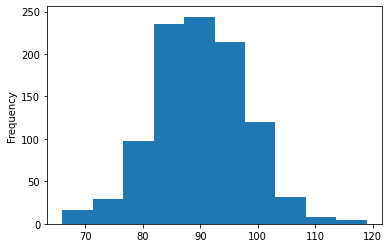

In [9]:
drawset_pd = sim_data.draws_pd()
drawset_pd.columns

# restrict to columns over new outcomes of N Bernoulli trials
y_sims = drawset_pd.drop(columns=['lp__', 'accept_stat__'])

# plot total number of successes per draw
y_sums = y_sims.sum(axis=1)
y_sums.astype('int32').plot.hist(range(0,datagen_data['N']+1))